## Import libraries and set dataset paths


In [4]:
from pathlib import Path

import datetime
from lib.dataloader import *


# Directory paths for semantic segmentation dataset
root_dir = Path("/home/emilia/WaterSegNet/datasets/complete_dataset/")

dir_test_img = root_dir / "test/images"
dir_test_mask = root_dir / "test/labels"
dir_train_img = root_dir / "train/images"
dir_train_mask = root_dir / "train/labels"
dir_valid_img = root_dir / "valid/images"
dir_valid_mask = root_dir / "valid/labels"

# Directory paths for checkpoints and best models
dir_checkpoint = root_dir / "checkpoints/"
dir_best_model = root_dir / "best_models/"
dir_best_model /= datetime.datetime.now().strftime("%d-%m-%Y-%H-%M")


train_set = SegDataset(dir_train_img, dir_train_mask)
valid_set = SegDataset(dir_valid_img, dir_valid_mask)
test_set = SegDataset(dir_test_img, dir_test_mask)

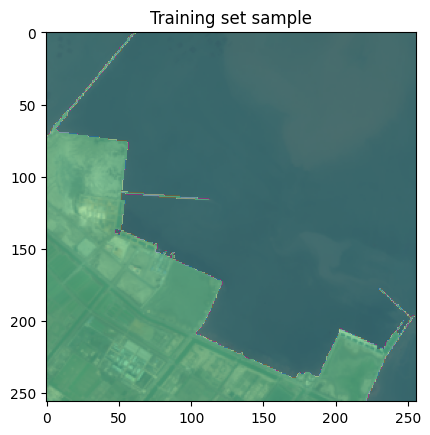

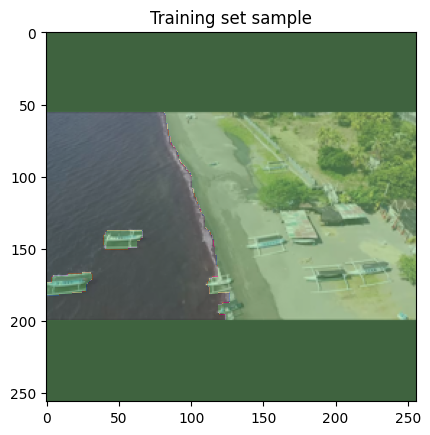

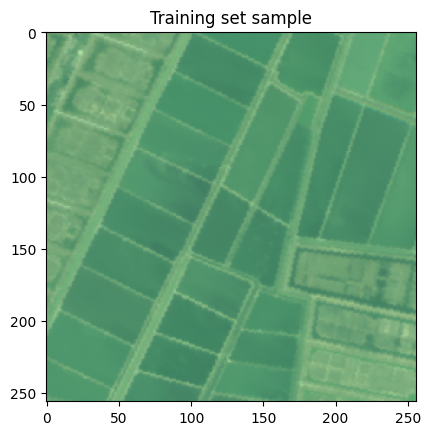

In [5]:
import matplotlib.pyplot as plt

for i in range(0, 3):
    sample = test_set[i]
    img, mask = sample["image"], sample["mask"]
    # for visualization we have to transpose back to HWC
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.imshow(mask, alpha=0.5, cmap="Accent")
    plt.title("Training set sample")
    plt.show()

## Train


In [6]:
from lib.train import *
import segmentation_models_pytorch as smp
import torchmetrics
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None,
)


model = model.to(memory_format=torch.channels_last)

metrics = torchmetrics.MetricCollection(
    torchmetrics.Accuracy(task="binary", num_classes=1, multiclass=False),
    torchmetrics.Recall(task="binary", num_classes=1, multiclass=False),
    torchmetrics.Precision(task="binary", num_classes=1, multiclass=False),
    torchmetrics.F1Score(
        task="binary", num_classes=1, multiclass=False
    ),  # Dice Coefficient
)

train_metrics = torchmetrics.MetricTracker(metrics)
val_metrics = torchmetrics.MetricTracker(metrics)
test_metrics = torchmetrics.MetricTracker(metrics)


seg_model = SegModel(
    model,
    lr=1e-3,
    optimizer_type="adam",
    train_metrics=train_metrics,
    val_metrics=val_metrics,
    test_metrics=test_metrics,
    freeze_encoder=False,
)
data_module = SegDataModule(train_set, valid_set, test_set, batch_size=16)
model_name = "unet_resnet34_adam_padded_b16"

# Callbacks
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints/checkpoints_full/",
    save_top_k=1,
    monitor="val_loss",
    mode="min",
    filename="model-{}".format(model_name),
)
early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, verbose=True, mode="min"
)

tb_logger = TensorBoardLogger("lightning_logs/full/", name=model_name)

trainer = Trainer(
    max_epochs=200,
    gpus=1 if torch.cuda.is_available() else 0,
    callbacks=[checkpoint_callback, early_stopping],
    logger=tb_logger,
    precision=16,  # Mixed precision training
)

trainer.fit(seg_model, data_module)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type              | Params
-----------------------------------------------------------
0 | model                | Unet              | 24.4 M
1 | criterion            | BCEWithLogitsLoss | 0     
2 | dice_loss            | DiceLoss          | 0     
3 | train_metric_tracker | MetricTracker     | 0     
4 | val_metric_tracker   | MetricTracker     | 0     
5 | test_metric_tracker  | MetricTracker     | 0     
-----------------------------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
48.873    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 269/269 [00:29<00:00,  9.02it/s, loss=0.39, v_num=0] 

Metric val_loss improved. New best score: 0.412


Epoch 1: 100%|██████████| 269/269 [00:34<00:00,  7.81it/s, loss=0.381, v_num=0]

Metric val_loss improved by 0.059 >= min_delta = 0.0. New best score: 0.354


Epoch 4: 100%|██████████| 269/269 [00:34<00:00,  7.74it/s, loss=0.273, v_num=0]

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 0.304


Epoch 6: 100%|██████████| 269/269 [00:35<00:00,  7.68it/s, loss=0.343, v_num=0]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.277


Epoch 8: 100%|██████████| 269/269 [00:36<00:00,  7.44it/s, loss=0.217, v_num=0]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.270


Epoch 11: 100%|██████████| 269/269 [00:35<00:00,  7.57it/s, loss=0.18, v_num=0] 

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 0.228


Epoch 16: 100%|██████████| 269/269 [00:35<00:00,  7.67it/s, loss=0.184, v_num=0]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.212


Epoch 19: 100%|██████████| 269/269 [00:36<00:00,  7.46it/s, loss=0.15, v_num=0] 

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.190


Epoch 22: 100%|██████████| 269/269 [00:35<00:00,  7.48it/s, loss=0.103, v_num=0] 

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.182


Epoch 23: 100%|██████████| 269/269 [00:37<00:00,  7.13it/s, loss=0.147, v_num=0]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.170


Epoch 26: 100%|██████████| 269/269 [00:35<00:00,  7.58it/s, loss=0.109, v_num=0] 

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.165


Epoch 30: 100%|██████████| 269/269 [00:35<00:00,  7.61it/s, loss=0.117, v_num=0] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.163


Epoch 37: 100%|██████████| 269/269 [00:34<00:00,  7.80it/s, loss=0.0689, v_num=0]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.155


Epoch 38: 100%|██████████| 269/269 [00:35<00:00,  7.53it/s, loss=0.0778, v_num=0]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.149


Epoch 40: 100%|██████████| 269/269 [00:35<00:00,  7.60it/s, loss=0.0724, v_num=0]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.145


Epoch 42: 100%|██████████| 269/269 [00:35<00:00,  7.54it/s, loss=0.0659, v_num=0]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.144


Epoch 43:  17%|█▋        | 47/269 [00:08<00:38,  5.70it/s, loss=0.0598, v_num=0] 

## Prediction


In [5]:
import segmentation_models_pytorch as smp

checkpoint = torch.load(
    "/home/emilia/WaterSegNet/checkpoints/checkpoints_satelite/model-unet_resnet34_adam_padded_b16-v1.ckpt"
)

state_dict = checkpoint["state_dict"]

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=3,
    classes=1,
    activation=None,
)
# model = SegNet_model.SegNet(n_channels=3, n_classes=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.load_state_dict(state_dict)

<All keys matched successfully>

2560 2560
1440 2560


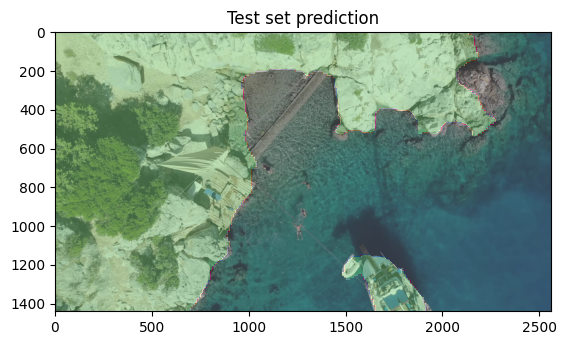

3840 3840
2160 3840


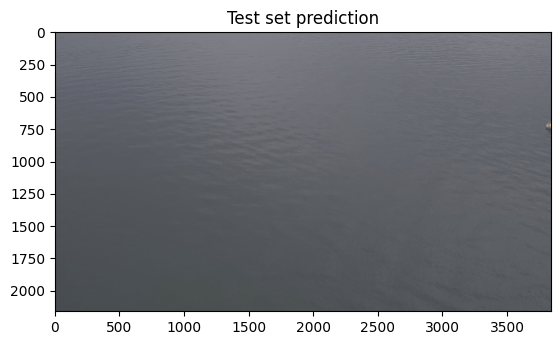

3840 3840
2160 3840


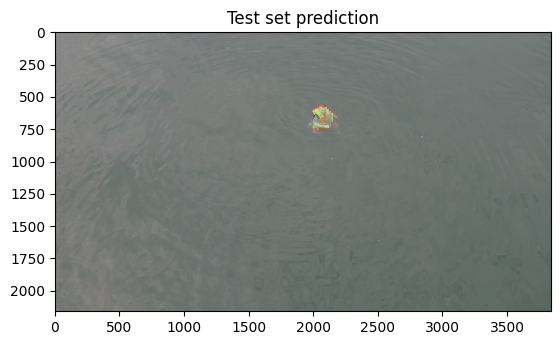

3840 3840
2160 3840


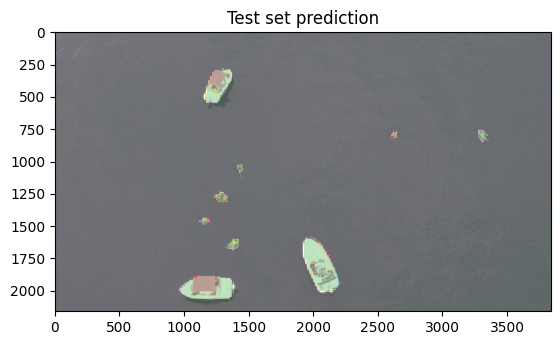

1920 1920
1012 1920


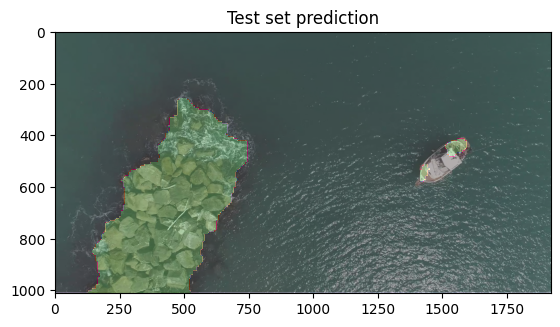

2560 2560
1440 2560


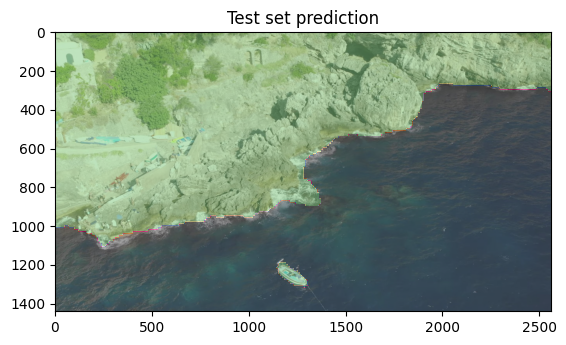

2560 2560
1440 2560


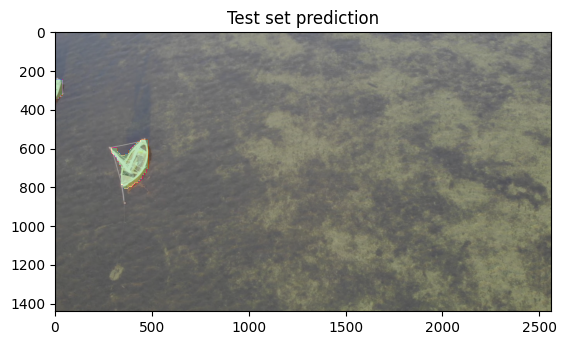

2560 2560
1440 2560


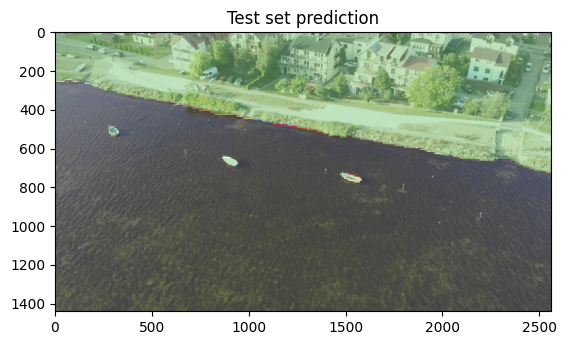

2560 2560
1440 2560


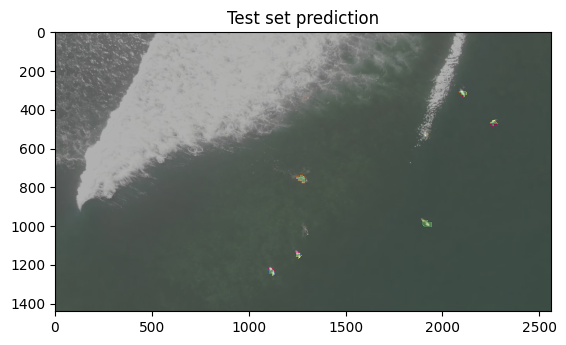

2560 2560
1440 2560


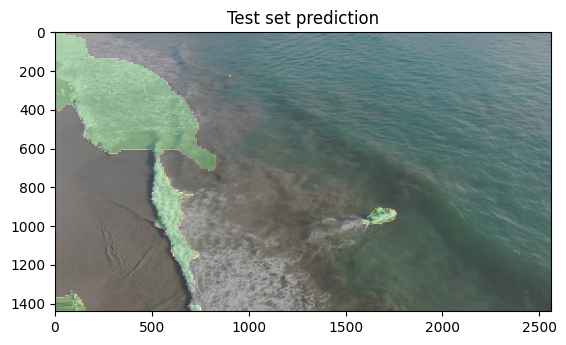

2720 2720
1530 2720


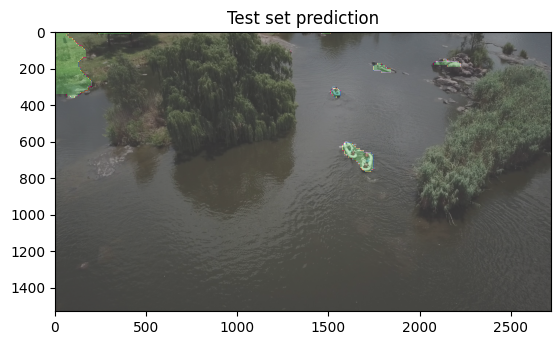

2720 2720
1530 2720


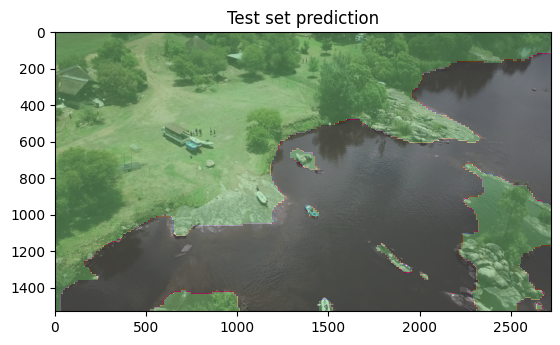

4275 4275
2850 4275


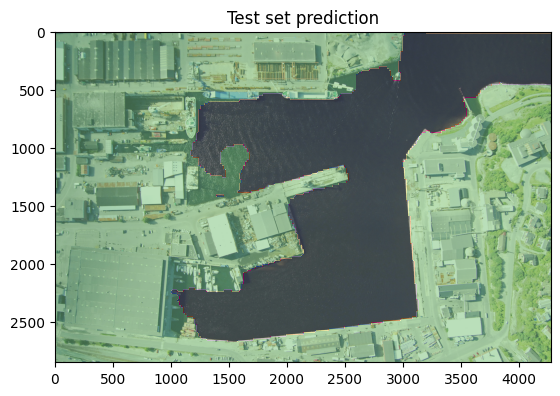

In [6]:
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F


def remove_border(mask, original_size):
    h, w = mask.shape
    orig_h, orig_w = original_size
    delta_w = w - orig_w
    delta_h = h - orig_h

    if delta_w > 0:
        mask = mask[:, delta_w // 2 : -delta_w // 2]
    if delta_h > 0:
        mask = mask[delta_h // 2 : -delta_h // 2, :]
    return mask


def predict_image(model, image, device):
    model.eval()
    img = torch.from_numpy(SegDataset.preprocess(image, is_mask=False))
    img = img.unsqueeze(0).to(device, dtype=torch.float32)
    with torch.no_grad():
        pred = model(img).cpu()
        max_dim = max(image.size)
        pred = F.interpolate(pred, size=(max_dim, max_dim))
        mask = torch.sigmoid(pred) > 0.5

    mask_np = mask[0].long().squeeze().numpy()
    mask_np = remove_border(mask_np, original_size=(image.size[1], image.size[0]))
    return mask_np


for i in range(1, 13):
    image_raw = Image.open("/home/emilia/WaterSegNet/test/" + str(i) + ".jpg")

    plt.imshow(image_raw)
    mask = predict_image(model, image_raw, device)
    plt.imshow(mask, alpha=0.5, cmap="Accent")
    plt.title("Test set prediction")
    plt.show()

image = Image.open("/home/emilia/WaterSegNet/test/trondheim.jpg")

plt.imshow(image)
mask = predict_image(model, image, device)
plt.imshow(mask, alpha=0.5, cmap="Accent")
plt.title("Test set prediction")
plt.show()

## Evaluate


In [17]:
%load_ext tensorboard